<a href="https://colab.research.google.com/github/TomokiArima/Simulation2024_Homework/blob/main/%E3%82%B7%E3%83%9F%E3%83%A5%E5%B7%A5_%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#スプレッドシートを操作するようにする認証のためのコード
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [34]:
#スプレッドシートのURLを入力
#url = input("スプレッドシートのURLを入力してください: ")
url = "https://docs.google.com/spreadsheets/d/1u59FrvBIKSjM3lLkIeGeJw0hZqnpe7FcYcmqenfxcjo/edit?gid=1906424505#gid=1906424505"  #@@@@デバック用、url入力を省く

try:
  sh = gc.open_by_url(url)
  print(f"スプレッドシート '{sh.title}' が正常に開かれました。")

  #スプレッドシートの最初のシートを取得
  worksheet = sh.sheet1

  start_row = input("開始行番号")  #得るセル範囲の開始行を入力
  #end_row = input("終了行番号")  #@@@@デバッグ用、終了行を入力→セル範囲は開始行から300行に決定
  end_row = int(start_row) + 100 #開始行から300セルの範囲を選択する

  cell_range = f"B{str(start_row)}:B{str(end_row)}" #得るセル範囲を文字列にする(B20:B60みたいなやつ)

  cell_values = worksheet.range(cell_range) #{シートを取得した奴}.range(セル範囲)でセルを含むリストを得る

  #セルオブジェクトの中から値のみをfloat型として抽出して配列に変換(.range()だけでは値以外に行・列など余計な情報を含んでいるので)
  V_call = [] #とりあえず空のリストを作る
  for i in cell_values: #ループで cell_value から値をとりだす
    try:
      V_call.append(float(i.value)) #{インデックス}.valueでi番目の要素を文字列で取り出す。それをfloat型に変換してV_callという配列に追加
    except ValueError:
      print(f"エラーが発生しました、範囲に空白や文字列が含まれているかも: {e}")

  # 配列を表示
  print(f"取得したデータ (B列 {start_row}行から{end_row}行):")
  print(V_call)
  print("配列の長さは",len(V_call))


except gspread.exceptions.SpreadsheetNotFound:
  print("指定されたURLのスプレッドシートは見つかりませんでした。")
except Exception as e:
  print(f"エラーが発生しました: {e}")

スプレッドシート 'シミュ工用 mass3_t1.0 (1).CSV' が正常に開かれました。
開始行番号129
取得したデータ (B列 129行から229行):
[-3.36, -3.36, -3.28, -2.8, -2.32, -1.68, -0.88, -0.32, 0.32, 0.72, 1.04, 1.36, 1.52, 1.36, 1.28, 1.04, 0.64, 0.16, -0.32, -0.88, -1.44, -2.0, -2.32, -2.48, -2.64, -2.48, -2.16, -1.76, -1.12, -0.32, 0.4, 1.28, 2.0, 2.64, 3.36, 3.68, 3.84, 3.76, 3.52, 3.12, 2.56, 1.92, 1.28, 0.72, 0.08, -0.48, -0.88, -1.2, -1.36, -1.44, -1.36, -1.12, -0.88, -0.56, -0.32, 0.0, 0.16, 0.32, 0.4, 0.48, 0.4, 0.32, 0.16, 0.0, -0.24, -0.56, -0.88, -1.12, -1.36, -1.44, -1.52, -1.52, -1.44, -1.2, -0.88, -0.56, -0.24, 0.16, 0.64, 1.04, 1.36, 1.6, 1.92, 2.0, 2.0, 2.0, 1.84, 1.6, 1.36, 1.04, 0.72, 0.48, 0.16, 0.0, -0.24, -0.32, -0.32, -0.32, -0.32, -0.24, -0.16]
配列の長さは 101


最小二乗平均誤差 0.04692416649742133 その時のi 27.60000000000025   その時のj 0.68


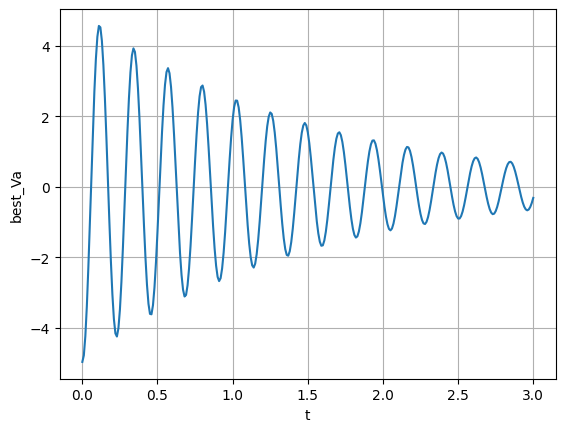

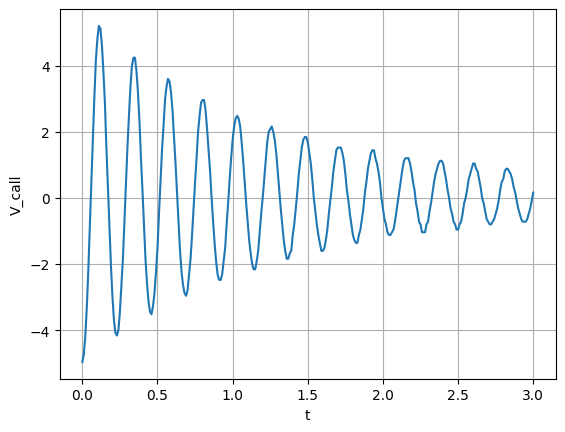

In [18]:
#初期変位x0 自動調整

import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from IPython.display import display,clear_output

#減衰の式
def DampedOscillation (w0,k,x0,wd, t):
  x = [] #結果を格納するリストを初期化
  for ti in t: #tの各要素に対してループ、tiはi番目の配列の中身
    xi = x0 * (math.exp(-k * ti)) *(math.cos(wd * ti) + ((k/wd) * math.sin(wd * ti)))
    x.append(xi) # 結果をリストに追加
  return np.array(x) #リストをNumPy配列に変換して返す


#条件
t_max = len(V_call)*0.01 #時間範囲をV_callと同じ長さにする(配列の長さを揃える)
t = np.arange(0, t_max, 0.01)  #時間範囲(配列の長さをV_callと揃える)
x0 = V_call[0]  #初期変位x0
Va = None
Vb = None

w0a = np.arange(10,40,0.05)  #w0：固有角振動数 (実験～w0aは10～40の間に来ると想定している)
ka = np.arange(0,1.0,0.01) #k：減衰係数
w0b = np.arange(10,40,0.05)  #w0：固有角振動数
kb = np.arange(0,1.0,0.01)

mse_min = 100

for w0a_i in w0a: #w0aを走査
  for ka_j in ka: #kaを走査
    try:
      Va = None #Vaの中身をリセット
      wda = math.sqrt((w0a_i**2) - (ka_j**2))  #wd：角振動数(減衰有)
      Va = DampedOscillation(w0a_i,ka_j,x0,wda,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

    except ValueError:
            print("Error: wd=√(ω₀a² - ka²)が負になった可能性")

  #二乗平均誤差が最小のものを探し出す
    mse_new = np.mean((Va - V_call) ** 2) #二乗平均誤差を計算(Mean Squared Error (MSE))
    if mse_new < mse_min:
      mse_min = mse_new #mse_minを更新
      best_w0a = w0a_i  #最小の時のiを記録
      best_ka = ka_j  #最小の時のjを記録
      best_Va = Va #最小の時のVを記録

print("最小二乗平均誤差",mse_min,"その時のi",best_w0a,"  その時のj",best_ka)

#best_Vaを表示
plt.plot(t, best_Va)
plt.xlabel('t')
plt.ylabel('best_Va')
plt.grid(True)
plt.show()
#V_callを表示
plt.plot(t, V_call)
plt.xlabel('t')
plt.ylabel('V_call')
plt.grid(True)
plt.show()


In [32]:
#合成波推定ツール

import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from IPython.display import display,clear_output

#減衰の式
def DampedOscillation (w0,k,x0,wd, t):
  x = [] #結果を格納するリストを初期化
  for ti in t: #tの各要素に対してループ、tiはi番目の配列の中身
    xi = x0 * (math.exp(-k * ti)) *(math.cos(wd * ti) + ((k/wd) * math.sin(wd * ti)))
    x.append(xi) # 結果をリストに追加
  return np.array(x) #リストをNumPy配列に変換して返す

#Vaを計算する
def Calculate_Va():
  try:
        #Vaを算出
        Va_def = None #Vaの中身をリセット
        wda = math.sqrt((w0a_i**2) - (ka_j**2))  #wd：角振動数(減衰有)
        Va_def = DampedOscillation(w0a_i,ka_j,x0,wda,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

  except ValueError:
              print("Error: wd=√(ω₀a² - ka²)が負になった可能性")
  return Va_def

#Vbを計算する
def Calculate_Vb():
  try:
        #Vbを算出
        Vb_def = None #Vbの中身をリセット
        wdb = math.sqrt((w0b_i**2) - (kb_j**2))  #wd：角振動数(減衰有)
        Vb_def = DampedOscillation(w0b_i,kb_j,x0,wdb,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

  except ValueError:
              print("Error: wd=√(ω₀b² - kb²)が負になった可能性")
  return Vb_def

#条件
t_max = len(V_call)*0.01 #時間範囲をV_callと同じ長さにする(配列の長さを揃える)
t = np.arange(0, t_max, 0.01)  #時間範囲(配列の長さをV_callと揃える)
x0 = V_call[0]  #初期変位x0

w0a = np.arange(10,40,0.05)  #w0：固有角振動数 (実験～w0aは10～40の間に来ると想定している)
ka = np.arange(0,1.0,0.01) #k：減衰係数
w0b = np.arange(10,40,0.05)  #w0：固有角振動数
kb = np.arange(0,1.0,0.01)

mse_min = 100 #最小二乗誤差　初期値は仮で100としておく

counter = 0

#適合するグラフを総当たりする
for w0a_i in w0a: #w0aを走査
  for ka_j in ka: #kaを走査
    Va = Calculate_Va () #Vaを算出

    for w0b_i in w0a:
      for kb_j in ka:
        Vb = Calculate_Vb ()

        Vsum = Va + Vb  #二つのグラフを足し合わせる

        counter += 1 #counterを更新
        print("counter",counter)

        #二乗平均誤差が最小のものを探し出す
        mse_new = np.mean((Vsum - V_call) ** 2) #二乗平均誤差を計算(Mean Squared Error (MSE))
        if mse_new < mse_min:
          mse_min = mse_new #mse_minを更新
          best_w0a = w0a_i  #最小の時のiを記録
          best_ka = ka_j  #最小の時のjを記録
          best_Va = Va #最小の時のVを記録
          best_w0b = w0b_i
          best_kb = kb_j
          best_Vb = Vb
          best_Vsum = Vsum


#best_Vaを表示
print("aのグラフ","w0a",best_w0a,"  ka",best_ka)
plt.plot(t, best_Va)
plt.xlabel('t')
plt.ylabel('best_Va')
plt.grid(True)
plt.show()

#best_Vbを表示
print("bのグラフ","w0b",best_w0b,"  kb",best_kb)
plt.plot(t, best_Vb)
plt.xlabel('t')
plt.ylabel('best_Vb')
plt.grid(True)
plt.show()

#best_Vsumを表示
print("合成波のグラフ","二乗平均誤差",mse_min)
plt.plot(t, best_Vsum)
plt.xlabel('t')
plt.ylabel('best_Vsum')
plt.grid(True)
plt.show()

#V_callを表示
plt.plot(t, V_call)
plt.xlabel('t')
plt.ylabel('V_call')
plt.grid(True)
plt.show()



ストリーミング出力は最後の 5000 行に切り捨てられました。
counter 491504
counter 491505
counter 491506
counter 491507
counter 491508
counter 491509
counter 491510
counter 491511
counter 491512
counter 491513
counter 491514
counter 491515
counter 491516
counter 491517
counter 491518
counter 491519
counter 491520
counter 491521
counter 491522
counter 491523
counter 491524
counter 491525
counter 491526
counter 491527
counter 491528
counter 491529
counter 491530
counter 491531
counter 491532
counter 491533
counter 491534
counter 491535
counter 491536
counter 491537
counter 491538
counter 491539
counter 491540
counter 491541
counter 491542
counter 491543
counter 491544
counter 491545
counter 491546
counter 491547
counter 491548
counter 491549
counter 491550
counter 491551
counter 491552
counter 491553
counter 491554
counter 491555
counter 491556
counter 491557
counter 491558
counter 491559
counter 491560
counter 491561
counter 491562
counter 491563
counter 491564
counter 491565
counter 491566
counter 491567
counter 

KeyboardInterrupt: 

In [ ]:
#減衰波形観察ツール

import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from IPython.display import display,clear_output

#減衰の式
def DampedOscillation (w0,k,x0,wd, t):
  x = [] #結果を格納するリストを初期化
  for ti in t: #tの各要素に対してループ、tiはi番目の配列の中身
    xi = x0 * (math.exp(-k * ti)) *(math.cos(wd * ti) + ((k/wd) * math.sin(wd * ti)))
    x.append(xi) # 結果をリストに追加
  return np.array(x) #リストをNumPy配列に変換して返す


#条件
t = np.arange(0, 10, 0.01)  #時間範囲
x0 = 7  #初期変位x0
Va = None
Vb = None

#スライダーの設定
w0a_slider = widgets.FloatSlider(value=5, min=1, max=100, step=0.1, description='ω₀a:')  #w0：固有角振動数　(value=初期値、min,max=スライダー範囲、step=刻み幅、description=スライダータイトル)
ka_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01, description='ka:') #k：減衰係数
w0b_slider = widgets.FloatSlider(value=5, min=1, max=100, step=0.1, description='ω₀b:')  #w0：固有角振動数　(value=初期値、min,max=スライダー範囲、step=刻み幅、description=スライダータイトル)
kb_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01, description='kb:')

#グラフを出力する所を作成
output_a = widgets.Output()
output_b = widgets.Output()
output_c = widgets.Output()

#関数：スライダーの値が変更されたときの更新処理(a)
def update_plot_a(change):
  global Va  #Vをグローバル変数として扱う
  with output_a:  #グラフを出力する所のoutputを開く
    clear_output(True)   #以前の出力を削除する
    #スライダーの値をw0,kに代入する
    w0a = w0a_slider.value  #".value"でスライダーの値を取得する
    ka = ka_slider.value

    try:
      wda = math.sqrt((w0a**2) - (ka**2))  #wd：角振動数(減衰有)
      Va = DampedOscillation(w0a,ka,x0,wda,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

      plt.plot(t, Va)
      plt.xlabel('t')
      plt.ylabel('Va')
      plt.title(f'w0a = {w0a:.2f}, ka = {ka:.2f}, x₀a = {x0:.2f}')
      plt.grid(True) # グリッド表示
      plt.show()

      update_plot_sum() #update_plot_sumを呼び出す(値が変わったのでグラフを更新する)

    except ValueError:
            print("Error: wd=√(ω₀a² - ka²)が負になった可能性")

#関数：スライダーの値が変更されたときの更新処理(b)
def update_plot_b(change):
  global Vb  #Vをグローバル変数として扱う
  with output_b:  #グラフを出力する所のoutputを開く
    clear_output(True)   #以前の出力を削除する
    #スライダーの値をw0,kに代入する
    w0b = w0b_slider.value  #".value"でスライダーの値を取得する
    kb = kb_slider.value

    try:
      wdb = math.sqrt((w0b**2) - (kb**2))  #wd：角振動数(減衰有)
      Vb = DampedOscillation(w0b,kb,x0,wdb,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

      plt.plot(t, Vb)
      plt.xlabel('t')
      plt.ylabel('Vb')
      plt.title(f'w0b = {w0b:.2f}, kb = {kb:.2f}, x₀b = {x0:.2f}')
      plt.grid(True) # グリッド表示
      plt.show()

      update_plot_sum() #update_plot_sumを呼び出す(値が変わったのでグラフを更新する)

    except ValueError:
            print("Error: wd=√(ω₀b² - kb²)が負になった可能性")

#二つのグラフを足し合わせる関数
def update_plot_sum():
  with output_c:  #グラフを出力する所のoutputを開く
    clear_output(True)   #以前の出力を削除する

    Vsum = Va + Vb

    plt.plot(t, Vsum)
    plt.xlabel('t')
    plt.ylabel('Vsum')
    plt.title(f'Vsum = Va + Vb')
    plt.grid(True)
    plt.show()

#スライダーの値の変化を検知する
w0a_slider.observe(update_plot_a,names='value')  #names='value'でスライダーの値を検知する指定。　検知された際に呼び出す関数はupdate_plot_aもしくは_b
ka_slider.observe(update_plot_a, names='value')
w0b_slider.observe(update_plot_b, names='value')
kb_slider.observe(update_plot_b, names='value')

display(w0a_slider, ka_slider, output_a) #スライダーと出力エリアをNotebook上に表示
display(w0b_slider, kb_slider, output_b)
display(output_c,)


update_plot_a(None)
update_plot_b(None)
update_plot_sum()



FloatSlider(value=5.0, description='ω₀a:', min=1.0)

FloatSlider(value=0.1, description='ka:', max=1.0, min=0.01, step=0.01)

Output()

FloatSlider(value=5.0, description='ω₀b:', min=1.0)

FloatSlider(value=0.1, description='kb:', max=1.0, min=0.01, step=0.01)

Output()

Output()